<a href="https://colab.research.google.com/github/prp20/tensorflow_learning/blob/main/practice_notebooks/practice_images_cassava_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle
! cp /content/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c cassava-leaf-disease-classification

100% 5.76G/5.76G [05:21<00:00, 19.5MB/s]
100% 5.76G/5.76G [05:21<00:00, 19.2MB/s]


In [ ]:
! unzip cassava-leaf-disease-classification.zip -d cassava_dataset

Streaming output truncated to the last 5000 lines.
  inflating: cassava_dataset/train_images/3954487465.jpg  
  inflating: cassava_dataset/train_images/3954910918.jpg  
  inflating: cassava_dataset/train_images/3955391972.jpg  
  inflating: cassava_dataset/train_images/3955442838.jpg  
  inflating: cassava_dataset/train_images/3955739563.jpg  
  inflating: cassava_dataset/train_images/3955931830.jpg  
  inflating: cassava_dataset/train_images/3955972139.jpg  
  inflating: cassava_dataset/train_images/3956075690.jpg  
  inflating: cassava_dataset/train_images/3956077728.jpg  
  inflating: cassava_dataset/train_images/3956155774.jpg  
  inflating: cassava_dataset/train_images/3956271103.jpg  
  inflating: cassava_dataset/train_images/3956372146.jpg  
  inflating: cassava_dataset/train_images/3956407201.jpg  
  inflating: cassava_dataset/train_images/3956550570.jpg  
  inflating: cassava_dataset/train_images/3956605397.jpg  
  inflating: cassava_dataset/train_images/3956778160.jpg  
  inf

In [ ]:
import os
import shutil
import pandas as pd
import random
import numpy as np

import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201

import cv2

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_df = pd.read_csv("cassava_dataset/train.csv")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


In [ ]:
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [ ]:
train_df['label'] = train_df['label'].astype(str)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  object
dtypes: object(2)
memory usage: 334.5+ KB


In [ ]:
def blur_preprocessing(img):
    return cv2.blur(img, (5, 5))

tf.random.set_seed(99)

## Initalize Image Data Generator with Augmentation
img_data_generator = ImageDataGenerator(rescale=1/255, 
                                        validation_split=0.2,
                                        rotation_range = 180,
                                        horizontal_flip = True,
                                        vertical_flip = True,
                                        preprocessing_function=blur_preprocessing
                                       )


## Recreate datasets from dataframe
train_data_multi = img_data_generator.flow_from_dataframe(dataframe=train_df,
                                                    directory="cassava_dataset/train_images/",
                                                    x_col="image_id",
                                                    y_col= "label",
                                                    target_size=(256, 256),
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    subset='training',
                                                    shuffle=True,
                                                    seed=42)

val_data_multi = img_data_generator.flow_from_dataframe(dataframe=train_df,
                                                    directory="cassava_dataset/train_images/",
                                                    x_col="image_id",
                                                    y_col="label",
                                                    target_size=(256, 256),
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    subset='validation',
                                                    shuffle=True,
                                                    seed=42)

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


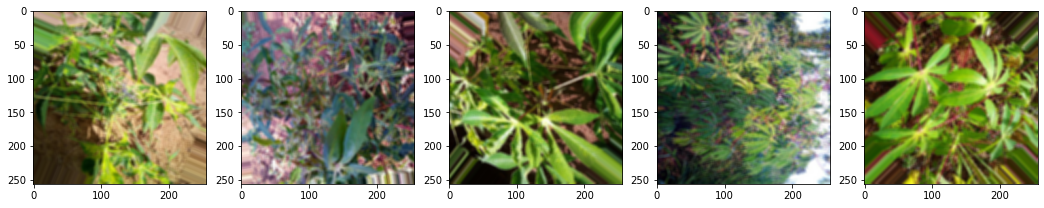

In [ ]:
def show_imgs(df, num):
    fig, ax = plt.subplots(1,num, figsize=(18,9))
    for x, y in df:
        for img in range(num):
            ax[img].imshow(x[img])
        break
show_imgs(train_data_multi, 5)

In [ ]:
# learning rate decay
learning_rate_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0003, 
                                                                         decay_steps=2, 
                                                                         decay_rate=0.97, 
                                                                         staircase=False)

In [ ]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs=None):
        self.patience = 3
        self.best = 0
        self.wait = 0
    
    def on_epoch_end(self, epoch, logs=None):
        if np.greater(logs["val_accuracy"], self.best):
            self.wait = 0
            self.best = logs["val_accuracy"]
        else:
            self.wait +=1
            if self.wait >= self.patience:
                print(f"Stopping Training. Validation accuracy hasn't improved >= {self.patience} times")
                self.model.stop_training=True

In [ ]:
def get_callbacks(model_name):
  callbacks = []
  MC = tf.keras.callbacks.ModelCheckpoint(f'saved_models/{model_name}.h5', monitor='val_loss', save_best_only='True', verbose=1)
  ES = EarlyStoppingCallback()
  return [MC, ES]

In [ ]:
def dense_net_model(trainable_weights=False, weights_path=None):
    
    tf.keras.backend.clear_session()
    
    dense_net = DenseNet201(input_shape=(256, 256, 3), weights="imagenet", include_top=False)
    
    for layer in dense_net.layers:
        layer.trainable=trainable_weights
    
    model = tf.keras.models.Sequential([dense_net,
                                        tf.keras.layers.GlobalAveragePooling2D(),
                                        tf.keras.layers.Dense(128, activation='relu'),
                                        tf.keras.layers.Dropout(0.3),
                                        tf.keras.layers.Dense(5, activation='softmax')
                                ])
    
    if weights_path:
        model.load_weights(weights_path)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler)
    
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    
    return model

dense_net_transfer = dense_net_model(trainable_weights=True)

dense_net_transfer_history = dense_net_transfer.fit(train_data_multi, validation_data=val_data_multi, epochs=25, steps_per_epoch=32, callbacks=get_callbacks("DenseNet"))

74836368/74836368 [==============================] - 4s 0us/step
Epoch 1/25
32/32 [==============================] - ETA: 0s - loss: 1.0491 - accuracy: 0.6299
Epoch 1: val_loss improved from inf to 2.12797, saving model to saved_models/DenseNet.h5
32/32 [==============================] - 273s 5s/step - loss: 1.0491 - accuracy: 0.6299 - val_loss: 2.1280 - val_accuracy: 0.6207
Epoch 2/25
32/32 [==============================] - ETA: 0s - loss: 0.8821 - accuracy: 0.6719
Epoch 2: val_loss improved from 2.12797 to 1.03089, saving model to saved_models/DenseNet.h5
32/32 [==============================] - 134s 4s/step - loss: 0.8821 - accuracy: 0.6719 - val_loss: 1.0309 - val_accuracy: 0.6681
Epoch 3/25
32/32 [==============================] - ETA: 0s - loss: 0.8481 - accuracy: 0.6680
Epoch 3: val_loss improved from 1.03089 to 0.94048, saving model to saved_models/DenseNet.h5
32/32 [==============================] - 134s 4s/step - loss: 0.8481 - accuracy: 0.6680 - val_loss: 0.9405 - val_accur

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

def create_VGG16_model():
    tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential()
    # initialize EfficientNetB3 model with input shape as (300,300,3)
    model.add(VGG16(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet'))
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(256, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(5, activation = 'softmax'))
    
    return model

model_2 = create_VGG16_model()

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler)
    
model_2.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

model_2_history = model_2.fit(train_data_multi, validation_data=val_data_multi, epochs=25, steps_per_epoch=128, callbacks=get_callbacks("VGG16"))

Epoch 1/25
128/128 [==============================] - ETA: 0s - loss: 1.2349 - accuracy: 0.5967
Epoch 1: val_loss improved from inf to 1.13659, saving model to saved_models/VGG16.h5
128/128 [==============================] - 261s 2s/step - loss: 1.2349 - accuracy: 0.5967 - val_loss: 1.1366 - val_accuracy: 0.6165
Epoch 2/25
128/128 [==============================] - ETA: 0s - loss: 1.1094 - accuracy: 0.6268
Epoch 2: val_loss improved from 1.13659 to 1.06984, saving model to saved_models/VGG16.h5
128/128 [==============================] - 215s 2s/step - loss: 1.1094 - accuracy: 0.6268 - val_loss: 1.0698 - val_accuracy: 0.6263
Epoch 3/25
128/128 [==============================] - ETA: 0s - loss: 1.1047 - accuracy: 0.6226
Epoch 3: val_loss improved from 1.06984 to 1.06464, saving model to saved_models/VGG16.h5
128/128 [==============================] - 215s 2s/step - loss: 1.1047 - accuracy: 0.6226 - val_loss: 1.0646 - val_accuracy: 0.6272
Epoch 4/25
128/128 [==============================

In [ ]:
preds_2 = model_2.predict_generator(val_data_multi, verbose=1, steps=607)
preds_2

134/607 [=====>........................] - ETA: 5:48

607/607 [==============================] - 99s 162ms/step


array([[0.02892967, 0.0550235 , 0.07890633, 0.7637178 , 0.07342273],
       [0.04604887, 0.0892365 , 0.099022  , 0.65770954, 0.10798306],
       [0.02511013, 0.04751381, 0.07011876, 0.79190826, 0.0653491 ],
       ...,
       [0.02014287, 0.04023371, 0.0637011 , 0.8204021 , 0.05552017],
       [0.02548902, 0.04790378, 0.07353913, 0.7878166 , 0.06525143],
       [0.04901505, 0.09041215, 0.10398425, 0.6491272 , 0.10746141]],
      dtype=float32)

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

def create_model():
    tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential()
    # initialize EfficientNetB3 model with input shape as (300,300,3)
    model.add(InceptionV3(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet'))
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(256, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(5, activation = 'softmax'))
    
    return model

model_3 = create_model()

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler)
    
model_3.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

model_3_history = model_3.fit(train_data_multi, validation_data=val_data_multi, epochs=25, steps_per_epoch=32, callbacks=get_callbacks("InceptionNet"))

Epoch 1/25
32/32 [==============================] - ETA: 0s - loss: 1.2001 - accuracy: 0.5859
Epoch 1: val_loss improved from inf to 2.22394, saving model to saved_models/InceptionNet.h5
32/32 [==============================] - 161s 4s/step - loss: 1.2001 - accuracy: 0.5859 - val_loss: 2.2239 - val_accuracy: 0.6165
Epoch 2/25
32/32 [==============================] - ETA: 0s - loss: 0.9596 - accuracy: 0.6484
Epoch 2: val_loss did not improve from 2.22394
32/32 [==============================] - 122s 4s/step - loss: 0.9596 - accuracy: 0.6484 - val_loss: 3.4789 - val_accuracy: 0.6167
Epoch 3/25
32/32 [==============================] - ETA: 0s - loss: 0.9286 - accuracy: 0.6475
Epoch 3: val_loss did not improve from 2.22394
32/32 [==============================] - 168s 5s/step - loss: 0.9286 - accuracy: 0.6475 - val_loss: 2.6919 - val_accuracy: 0.6195
Epoch 4/25
32/32 [==============================] - ETA: 0s - loss: 0.8437 - accuracy: 0.6885
Epoch 4: val_loss improved from 2.22394 to 1.90

In [ ]:
from tensorflow.keras.applications import ResNet50

def create_model():
    tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential()
    # initialize EfficientNetB3 model with input shape as (300,300,3)
    model.add(ResNet50(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet', pooling='max'))
    model.add(tf.keras.layers.Dense(256, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(5, activation = 'softmax'))
    
    return model

model_4 = create_model()

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler)
    
model_4.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

model_4_history = model_4.fit(train_data_multi, validation_data=val_data_multi, epochs=25, steps_per_epoch=32, callbacks=get_callbacks("ResNet50"))

94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/25
32/32 [==============================] - ETA: 0s - loss: 6.6248 - accuracy: 0.4902
Epoch 1: val_loss improved from inf to 34.41778, saving model to saved_models/ResNet50.h5
32/32 [==============================] - 164s 4s/step - loss: 6.6248 - accuracy: 0.4902 - val_loss: 34.4178 - val_accuracy: 0.1019
Epoch 2/25
32/32 [==============================] - ETA: 0s - loss: 1.8261 - accuracy: 0.5479
Epoch 2: val_loss improved from 34.41778 to 3.43093, saving model to saved_models/ResNet50.h5
32/32 [==============================] - 123s 4s/step - loss: 1.8261 - accuracy: 0.5479 - val_loss: 3.4309 - val_accuracy: 0.1192
Epoch 3/25
32/32 [==============================] - ETA: 0s - loss: 1.2378 - accuracy: 0.5762
Epoch 3: val_loss did not improve from 3.43093
32/32 [==============================] - 122s 4s/step - loss: 1.2378 - accuracy: 0.5762 - val_loss: 4.3085 - val_accuracy: 0.1192
Epoch 4/25
32/32 [=============